# Fraud Detection & Network Anomaly Detection (Cybersecurity Hybrid)

This notebook trains models for transaction fraud detection and network anomaly detection, includes SHAP explanations, and saves model artifacts for the demo.



In [45]:
# Imports and setup
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc
import joblib
import shap

BASE = Path('.').resolve()
DATA_DIR = BASE / 'data'
MODELS_DIR = BASE / 'models'
DATA_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)
print('Paths set.')


Paths set.


In [19]:
try:
    import kagglehub
    path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
    data_file = Path(path) / "creditcard.csv"
except Exception as e:
    print(" kagglehub failed, using Kaggle API instead:", e)
    os.system("kaggle datasets download -d mlg-ulb/creditcardfraud -p data --unzip")
    data_file = Path("data/creditcard.csv")

df = pd.read_csv(data_file)
print("Loaded:", df.shape)


Loaded: (284807, 31)


In [20]:
# Preprocess and train a Random Forest on a balanced subset (demo)
if 'df' in globals():
    df['Hour'] = (df['Time'] // 3600) % 24
    scaler = StandardScaler()
    df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
    fraud = df[df['Class']==1]
    nonfraud = df[df['Class']==0].sample(n=5000, random_state=42)
    df_bal = pd.concat([fraud, nonfraud]).sample(frac=1, random_state=42)
    X = df_bal.drop(['Class','Time','Amount'], axis=1)
    y = df_bal['Class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(classification_report(y_test, y_pred))
    joblib.dump(rf, MODELS_DIR / 'rf_fraud.pkl')
    joblib.dump(scaler, MODELS_DIR / 'scaler_amount.pkl')
    print('Saved rf_fraud.pkl and scaler_amount.pkl')
else:
    print('Dataset not loaded.')


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1001
           1       0.95      0.82      0.88        98

    accuracy                           0.98      1099
   macro avg       0.97      0.91      0.93      1099
weighted avg       0.98      0.98      0.98      1099

Saved rf_fraud.pkl and scaler_amount.pkl


Preparing SHAP explanations...
SHAP values shape: (200, 30, 2)
Sample shape: (200, 30)
Plotting SHAP summary...


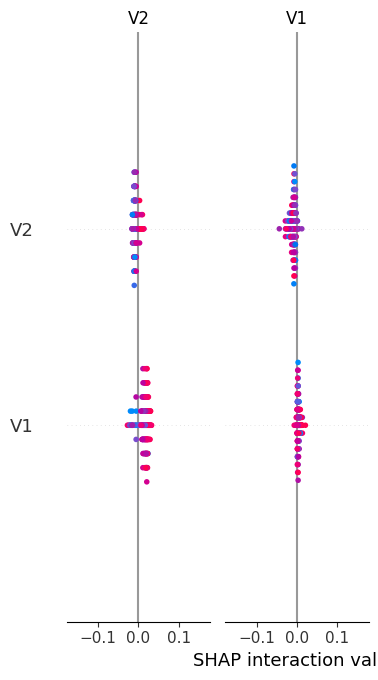

 Saved shap_summary.png successfully.


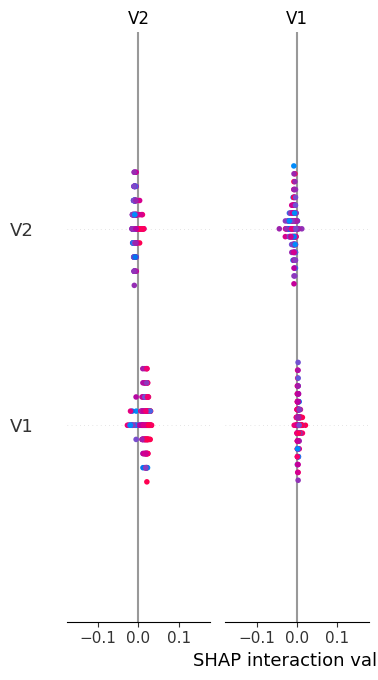

In [22]:
import shap
import matplotlib.pyplot as plt
import numpy as np

if 'rf' in globals():
    print("Preparing SHAP explanations...")

    feature_cols = X_train.columns
    sample = X_test[feature_cols].sample(200, random_state=42)

    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(sample)

    # handle cases where SHAP returns [class0, class1] or combined array
    if isinstance(shap_values, list):
        shap_matrix = shap_values[1]  # class 1 = fraud
    else:
        shap_matrix = shap_values

    print("SHAP values shape:", np.array(shap_matrix).shape)
    print("Sample shape:", sample.shape)

    # ensure the second dimension matches feature count
    assert shap_matrix.shape[1] == sample.shape[1], "Feature dimension mismatch."

    print("Plotting SHAP summary...")
    shap.summary_plot(shap_matrix, sample, show=True)

    # save a PNG version
    shap.summary_plot(shap_matrix, sample, show=False)
    plt.savefig('shap_summary.png', bbox_inches='tight')
    print(" Saved shap_summary.png successfully.")
else:
    print("RF not trained yet.")


In [24]:
# ==========================================
# Generate synthetic network dataset (demo)
# ==========================================
import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

np.random.seed(42)
n_records = 5000

# Define protocol and address pools
protocols = ["TCP", "UDP", "ICMP"]
src_ips = [f"192.168.1.{i}" for i in range(1, 51)]
dst_ips = [f"10.0.0.{i}" for i in range(1, 201)]

# Create synthetic network log
net_df = pd.DataFrame({
    "src_ip": np.random.choice(src_ips, n_records),
    "dst_ip": np.random.choice(dst_ips, n_records),
    "bytes": np.random.randint(100, 200000, n_records),
    "duration": np.random.uniform(0.01, 120.0, n_records),
    "timestamp": pd.date_range("2025-10-01", periods=n_records, freq="min"),
    "protocol": np.random.choice(protocols, n_records),
    "label": np.random.choice([0, 1], n_records, p=[0.97, 0.03])  # 3% suspicious
})

# Save dataset
net_file = DATA_DIR / "network_data.csv"
net_df.to_csv(net_file, index=False)

print(f" Synthetic network dataset created: {net_file}")
print("Shape:", net_df.shape)
print(net_df.head())


 Synthetic network dataset created: data\network_data.csv
Shape: (5000, 7)
         src_ip      dst_ip   bytes   duration           timestamp protocol  \
0  192.168.1.39   10.0.0.45   85535  25.808422 2025-10-01 00:00:00      UDP   
1  192.168.1.29  10.0.0.145   19887  85.879110 2025-10-01 00:01:00     ICMP   
2  192.168.1.15  10.0.0.104   21082  96.008528 2025-10-01 00:02:00      UDP   
3  192.168.1.43   10.0.0.85   22706  41.539408 2025-10-01 00:03:00      TCP   
4   192.168.1.8  10.0.0.194  141322  20.721367 2025-10-01 00:04:00      UDP   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  


In [68]:
# ======================================
# Network Anomaly Detection Model Training
# ======================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import joblib
from pathlib import Path

# ======================================
# 1. Define paths
# ======================================
DATA_DIR = Path("data")
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

# ======================================
# 2. Load your raw network data
# ======================================
# Replace with your actual dataset path
net_df = pd.read_csv(DATA_DIR / "network_data.csv")

# Expected columns: ['src_ip', 'dst_ip', 'bytes', 'duration', 'protocol', 'timestamp', 'label']

# ======================================
# 3. Aggregate network features per source IP
# ======================================
agg_src = net_df.groupby('src_ip').agg(
    conn_count=('timestamp', 'count'),
    avg_bytes=('bytes', 'mean'),
    max_bytes=('bytes', 'max'),
    avg_duration=('duration', 'mean'),
    unique_dst=('dst_ip', 'nunique'),
    suspicious_ratio=('label', 'mean')
).reset_index()

# Pivot protocols
proto = net_df.pivot_table(index='src_ip', columns='protocol', values='bytes',
                           aggfunc='count', fill_value=0).reset_index()

# Merge aggregates
net_features = agg_src.merge(proto, on='src_ip', how='left').fillna(0)

# ======================================
# 4. Define final feature columns
# ======================================
feature_cols = [
    'conn_count', 'avg_bytes', 'max_bytes', 'avg_duration',
    'unique_dst', 'TCP', 'UDP', 'ICMP'
]

# Ensure all required columns exist
for col in feature_cols:
    if col not in net_features.columns:
        net_features[col] = 0

# ======================================
# 5. Scale features
# ======================================
scaler_net = MinMaxScaler()
X_net = scaler_net.fit_transform(net_features[feature_cols])

# ======================================
# 6. Train IsolationForest model
# ======================================
iso_net = IsolationForest(contamination=0.01, random_state=42)
iso_net.fit(X_net)

# Add feature names to model (custom attribute)
iso_net.feature_names_in_ = np.array(feature_cols)

# ======================================
# 7. Save results
# ======================================
net_features['iso_score'] = iso_net.decision_function(X_net)
net_features['anomaly_flag'] = iso_net.predict(X_net)  # -1 = anomaly, 1 = normal

# Save aggregated dataset and models
net_features.to_csv(DATA_DIR / "network_aggregates.csv", index=False)
joblib.dump(iso_net, MODEL_DIR / "iso_network.pkl")
joblib.dump(scaler_net, MODEL_DIR / "scaler_network.pkl")

print("Network model trained and saved successfully!")
print("Features used during training:")
print(feature_cols)


Network model trained and saved successfully!
Features used during training:
['conn_count', 'avg_bytes', 'max_bytes', 'avg_duration', 'unique_dst', 'TCP', 'UDP', 'ICMP']


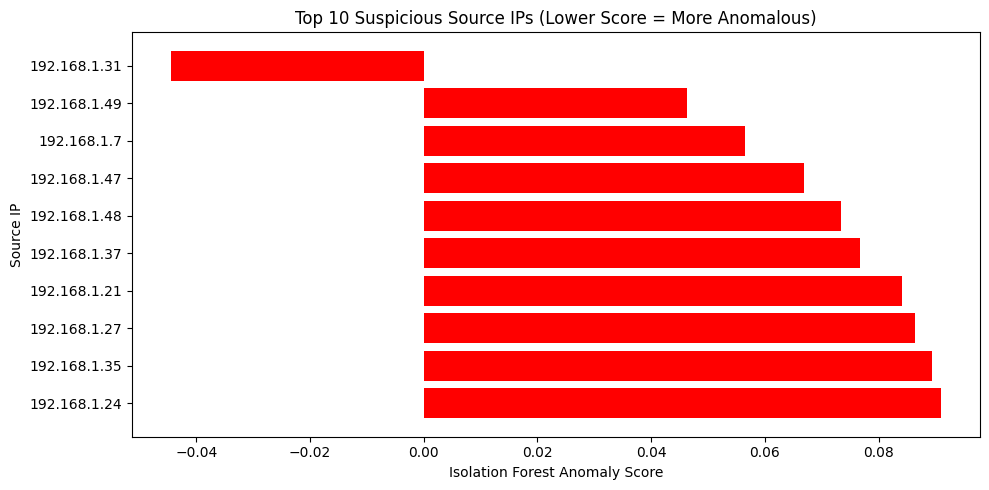

 Top 10 Suspicious IPs:


,src_ip,iso_score,suspicious_ratio,conn_count,unique_dst
24,192.168.1.31,-0.044520,0.043478,69,62
43,192.168.1.49,0.046338,0.048780,123,86
47,192.168.1.7,0.056486,0.026316,76,61
41,192.168.1.47,0.066880,0.032258,124,88
42,192.168.1.48,0.073379,0.011905,84,69
30,192.168.1.37,0.076743,0.053571,112,88
13,192.168.1.21,0.084171,0.034783,115,89
19,192.168.1.27,0.086435,0.000000,84,64
28,192.168.1.35,0.089384,0.025641,117,90
16,192.168.1.24,0.091039,0.019802,101,75


In [26]:
# ==========================================
# Visualize top suspicious source IPs
# ==========================================
import matplotlib.pyplot as plt

# Sort by anomaly score (lower = more anomalous)
top_suspicious = net_features.sort_values('iso_score').head(10)

plt.figure(figsize=(10,5))
plt.barh(top_suspicious['src_ip'], top_suspicious['iso_score'], color='red')
plt.xlabel("Isolation Forest Anomaly Score")
plt.ylabel("Source IP")
plt.title("Top 10 Suspicious Source IPs (Lower Score = More Anomalous)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(" Top 10 Suspicious IPs:")
display(top_suspicious[['src_ip', 'iso_score', 'suspicious_ratio', 'conn_count', 'unique_dst']])


In [27]:
# Optional: train a small autoencoder for network features (requires tensorflow)
try:
    from tensorflow import keras
    from tensorflow.keras import layers

    X_train_net = X_net
    input_dim = X_train_net.shape[1]
    encoding_dim = max(4, input_dim // 2)

    inputs = keras.Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu')(inputs)
    encoded = layers.Dense(encoding_dim // 2, activation='relu')(encoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = keras.Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    autoencoder.fit(X_train_net, X_train_net, epochs=10, batch_size=32, verbose=0)

    recon = autoencoder.predict(X_train_net)
    mse = (X_train_net - recon) ** 2
    net_features['ae_mse'] = mse.mean(axis=1)

    # Fixed saving line
    autoencoder.save(MODELS_DIR / 'autoencoder_network.keras')
    print('Autoencoder trained and saved as autoencoder_network.keras')

except Exception as e:
    print('TensorFlow not available or training failed:', e)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Autoencoder trained and saved as autoencoder_network.keras


In [28]:
# Models saved: rf_fraud.pkl, scaler_amount.pkl, iso_network.pkl, scaler_network.pkl, (autoencoder_network)
print('Models are saved in models/; use app/main.py to serve predictions via FastAPI.')


Models are saved in models/; use app/main.py to serve predictions via FastAPI.
